# Regression with a Tabular California Housing Dataset
### Playground Series - Season 3, Episode 1
https://www.kaggle.com/competitions/playground-series-s3e1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats import pearsonr

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split

# linear models
from sklearn.linear_model import Ridge, LinearRegression, Lars, BayesianRidge, Perceptron, SGDRegressor
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV, LassoLarsCV, OrthogonalMatchingPursuit, ARDRegression
from sklearn.linear_model import PassiveAggressiveClassifier, TheilSenRegressor, HuberRegressor, GammaRegressor

# tree models
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor

# svm models
from sklearn.svm import LinearSVR, NuSVR, SVR

# closed neural network models
from sklearn.neural_network import MLPRegressor

# ensemble models
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# others
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# stack
from mlxtend.regressor import StackingCVRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [4]:
train.describe()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,37137.00000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000
mean,18568.00000,3.851029,26.057005,5.163124,1.062204,1660.778919,2.831243,35.570030,-119.554329,2.079751
std,10720.67281,1.803167,12.158221,1.206242,0.096490,1302.469608,2.702413,2.083179,1.974028,1.158571
min,0.00000,0.499900,2.000000,0.851064,0.500000,3.000000,0.950000,32.550000,-124.350000,0.149990
25%,9284.00000,2.602300,17.000000,4.357522,1.020305,952.000000,2.394495,33.930000,-121.800000,1.208000
50%,18568.00000,3.515600,25.000000,5.068611,1.054545,1383.000000,2.744828,34.190000,-118.450000,1.808000
75%,27852.00000,4.699700,35.000000,5.858597,1.088825,1856.000000,3.125313,37.700000,-118.020000,2.660000
max,37136.00000,15.000100,52.000000,28.837607,5.873181,35682.000000,502.990610,41.950000,-114.550000,5.000010


In [5]:
all_data = pd.concat((train.loc[:, 'MedInc':'Longitude'], test.loc[:, 'MedInc':'Longitude']))

In [6]:
train['MedHouseVal'] = np.log1p(train['MedHouseVal'])

In [7]:
# selecionando features numéricas
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
# calculando skew (assimetria)
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
# filtro por skew maior que 0.75 (perto de zero é normal)
skewed_feats = skewed_feats[skewed_feats > 0.75]
# selecionando índices para normalização
skewed_feats = skewed_feats.index
# normalizando por log(x + 1)
all_data[skewed_feats] = np.log1p(all_data[skewed_feats]) 

In [8]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.median())

In [9]:
# criando treino
X = all_data[:train.shape[0]]

# criando o teste
test = all_data[train.shape[0]:]

# criando o target
y = train.MedHouseVal

# normalizando treino e teste
# X = scale(X)
# test = scale(test)

In [10]:
results = {
    'Model':[],
    'MAE':[],
    'RMSE':[],
    'EVS':[]
}

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
model_instances = [
    # LINEAR
    (Ridge(), 'Ridge'), 
    (RidgeCV(), 'Ridge CV'),
    (LassoCV(), 'LASSO CV'),
    (LinearRegression(), 'Linear Regression'),
    (BayesianRidge(), 'Bayesian Rigde'),
    (ElasticNet(), 'Elastic Net'),
    (OrthogonalMatchingPursuit(), 'Orthogonal Matching Pursuit'),
    (ARDRegression(), 'ARD Regression'),
    # TREE
    (ExtraTreeRegressor(), 'Extra Tree'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    # SVM
    (LinearSVR(max_iter=100), 'Linear SVR'),
    (NuSVR(max_iter=100), 'NuSVR'),
    (SVR(max_iter=100), 'SVR'),
    # NN
    (MLPRegressor(max_iter=100, activation='tanh'), 'MLPRegressor'), # 1000 and 10000 hasn't converged
    # BOOST
    (AdaBoostRegressor(), 'Ada boost'),
    (BaggingRegressor(), 'Bagging'),
    (GradientBoostingRegressor(n_estimators=700), 'Gradient Boosting'),
    (RandomForestRegressor(), 'Random Forest'),
    # State of Art
    (XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,nthread=4,scale_pos_weight=1,
                     reg_alpha=0.00006), 'XGBoost'),
    (LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,verbose=0,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11), 'LightGBM'),
    (CatBoostRegressor(verbose=False), 'CatBoost'),
]

In [13]:
for model, model_name in model_instances:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results['Model'].append(model_name)
    results['MAE'].append(mean_absolute_error(y_test, y_pred))
    results['RMSE'].append(mean_squared_error(y_test, y_pred, squared=True))
    results['EVS'].append(explained_variance_score(y_test, y_pred))

c:\Users\gabri\Documents\UFTM\Introdução à Ciência de Dados\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\gabri\Documents\UFTM\Introdução à Ciência de Dados\env\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\gabri\Documents\UFTM\Introdução à Ciência de Dados\env\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [14]:
results = pd.DataFrame(results)
results

,Model,MAE,RMSE,EVS
0,Ridge,0.160258,0.043320,0.659313
1,Ridge CV,0.160258,0.043318,0.659329
2,LASSO CV,0.160423,0.043469,0.658143
3,Linear Regression,0.160258,0.043318,0.659331
4,Bayesian Rigde,0.160258,0.043319,0.659326
5,Elastic Net,0.290878,0.127143,0.000000
6,Orthogonal Matching Pursuit,0.290322,0.126362,0.006178
7,ARD Regression,0.161747,0.044144,0.652821
8,Extra Tree,0.187580,0.062910,0.505139
9,Decision Tree,0.185231,0.061949,0.512835


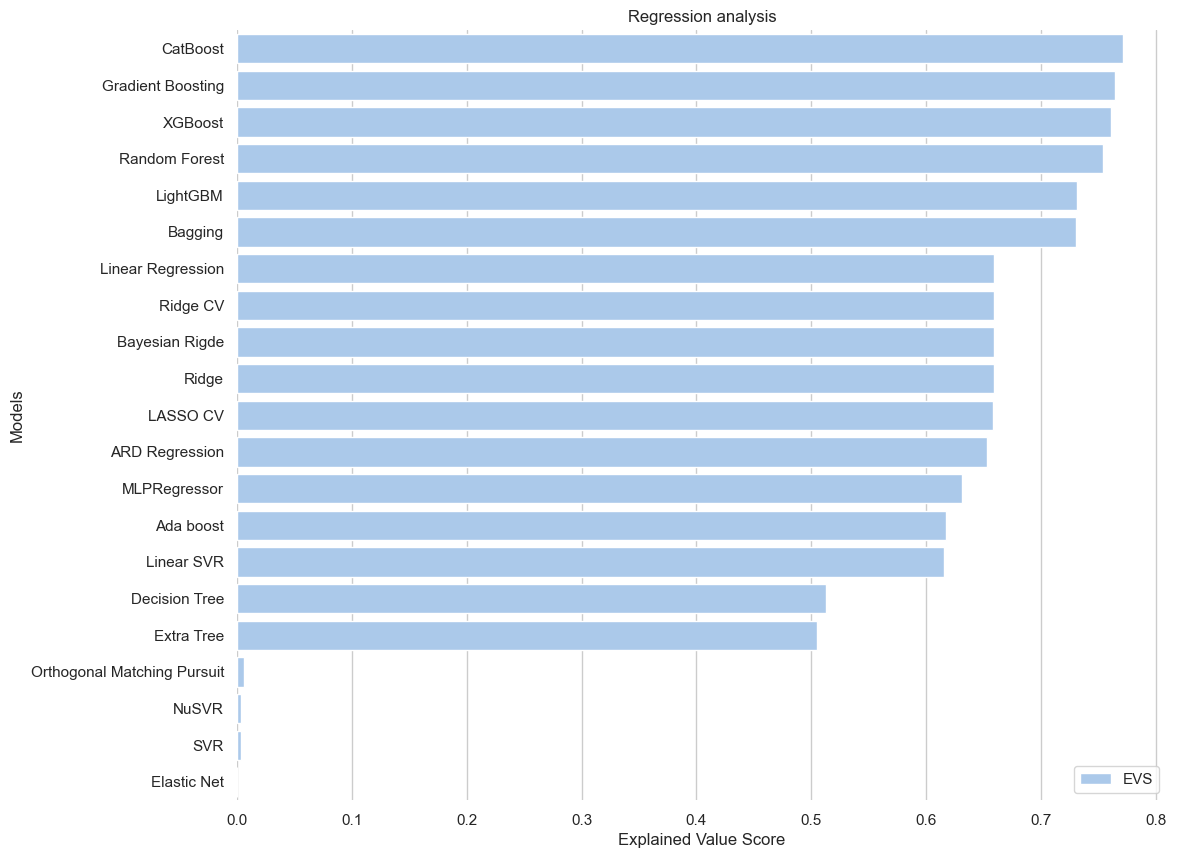

In [15]:
sns.set(style='whitegrid')
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Plot the total crashes
sns.set_color_codes('pastel')
results_temp = results.sort_values('EVS', ascending=False)
sns.barplot(x='EVS', y='Model', data=results_temp,
            label='EVS', color='b')
# Add a legend and informative axis label
ax.legend(ncol=2, loc='lower right', frameon=True)
ax.set(ylabel='Models',
       xlabel='Explained Value Score',title='Regression analysis')
sns.despine(left=True, bottom=True)
plt.show()

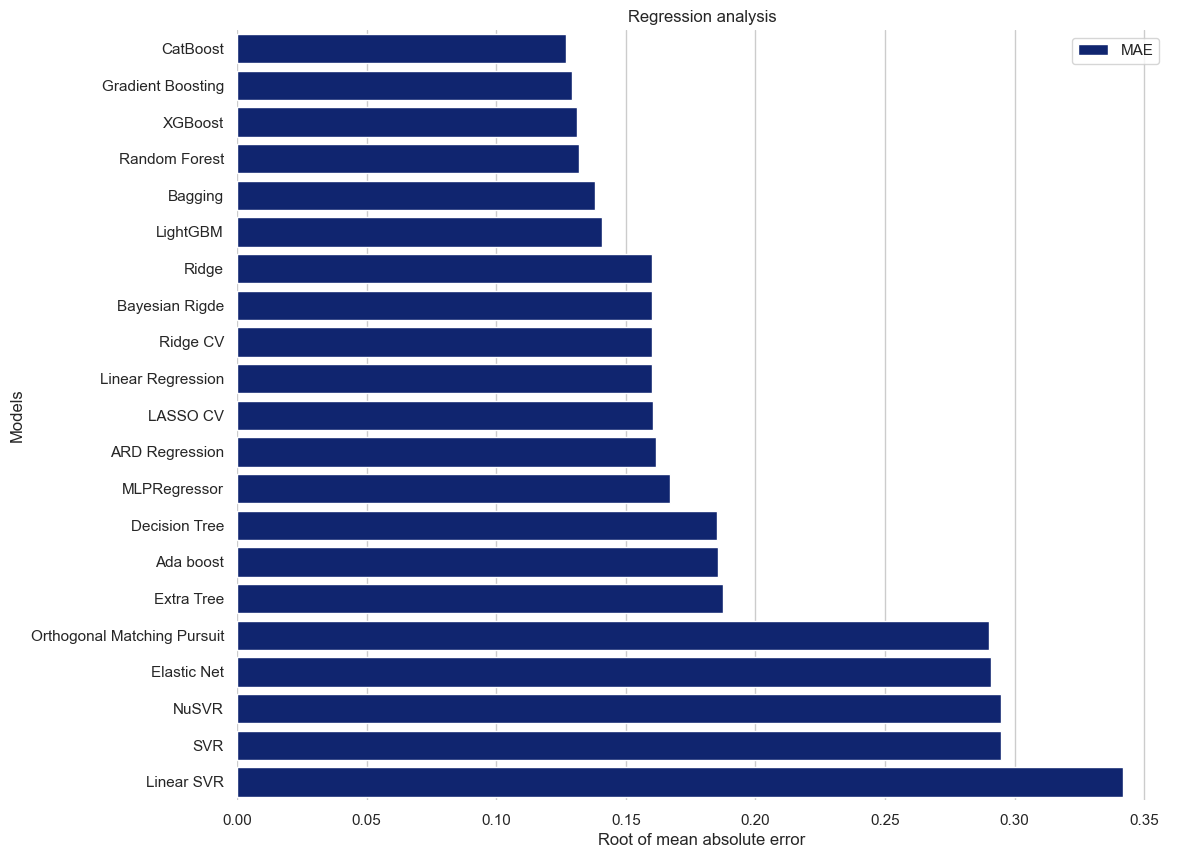

In [16]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Plot the total crashes
sns.set_color_codes('dark')
results_temp = results.sort_values('MAE', ascending=True)
sns.barplot(x='MAE', y='Model', data=results_temp,
            label='MAE', color='b')
# Add a legend and informative axis label
ax.legend(ncol=2, loc='upper right', frameon=True)
ax.set(ylabel='Models',
       xlabel='Root of mean absolute error',title='Regression analysis')
sns.despine(left=True, bottom=True)
plt.show()

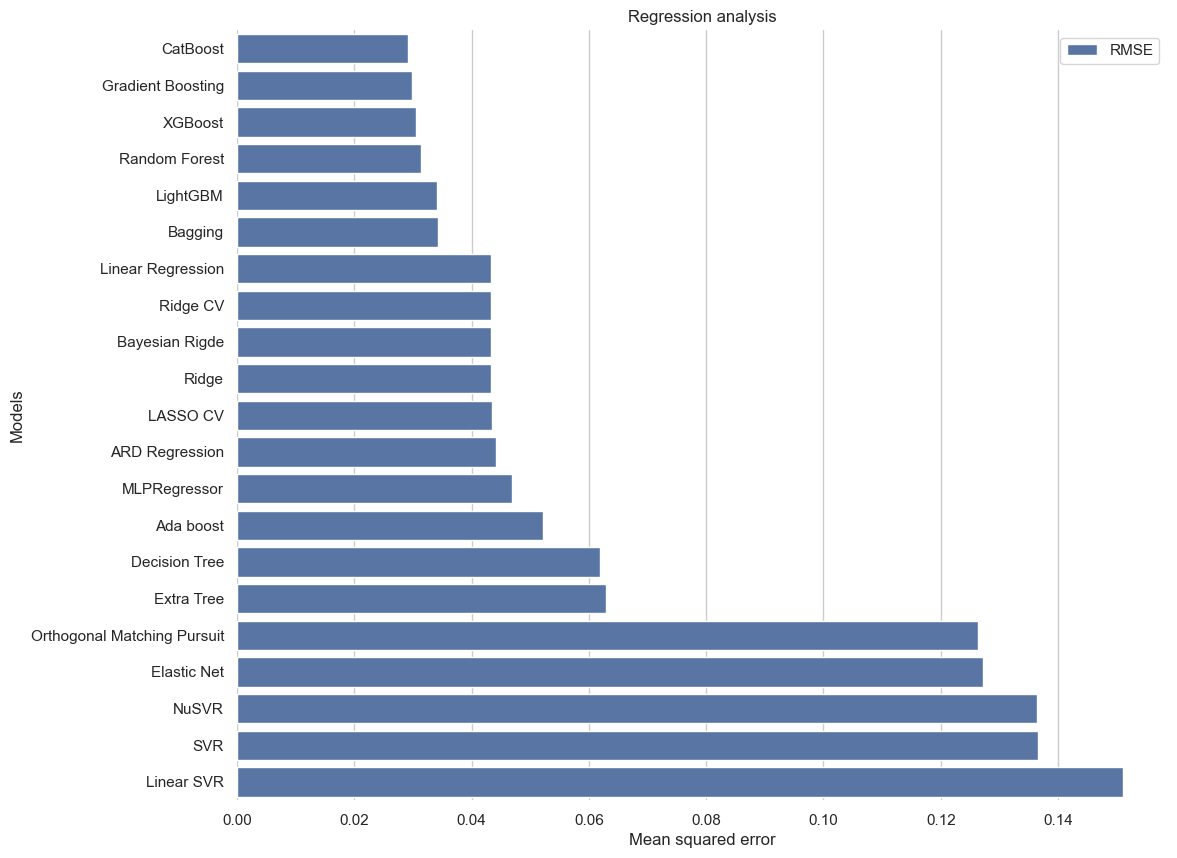

In [17]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Plot the total crashes
sns.set_color_codes()
results_temp = results.sort_values('RMSE', ascending=True) # just the 8 first.iloc[:8]
sns.barplot(x='RMSE', y='Model', data=results_temp,
            label='RMSE', color='b')
# Add a legend and informative axis label
ax.legend(ncol=2, loc='upper right', frameon=True)
ax.set(ylabel='Models',
       xlabel='Mean squared error',title='Regression analysis')
sns.despine(left=True, bottom=True)
plt.show()

In [18]:
results_temp = results.sort_values('EVS', ascending=False)
results_temp.iloc[:5]['Model']

20             CatBoost
16    Gradient Boosting
18              XGBoost
17        Random Forest
19             LightGBM
Name: Model, dtype: object

In [19]:
results_temp = results.sort_values('MAE', ascending=True)
results_temp.iloc[:5]['Model']

20             CatBoost
16    Gradient Boosting
18              XGBoost
17        Random Forest
15              Bagging
Name: Model, dtype: object

In [20]:
results_temp = results.sort_values('RMSE', ascending=True)
results_temp.iloc[:5]['Model']

20             CatBoost
16    Gradient Boosting
18              XGBoost
17        Random Forest
19             LightGBM
Name: Model, dtype: object

In [21]:
cat = CatBoostRegressor(verbose=False)

grad = GradientBoostingRegressor(n_estimators=700)

xgb = XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,nthread=4,scale_pos_weight=1,
                     reg_alpha=0.00006)

stack_gen=StackingCVRegressor(
    regressors=(cat, grad, xgb),
    meta_regressor=cat,
    use_features_in_secondary=True)

In [22]:
stack_gen.fit(X.values, y.values)
med_house_val_preds = stack_gen.predict(test.values)

In [23]:
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)
sample_submission['MedHouseVal'] = np.expm1(med_house_val_preds)
sample_submission.to_csv('med_house_val_preds.csv')